# Clustering and the Iris Data Set

Iris Data: 

* 4 features: Sepal Length, Sepal Width, Petal Length and Petal Width
* 3 known classes: Setosa, Versicolour, and Virginica


Automatically created module for IPython interactive environment


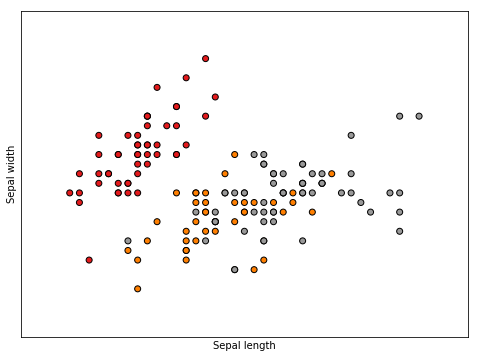

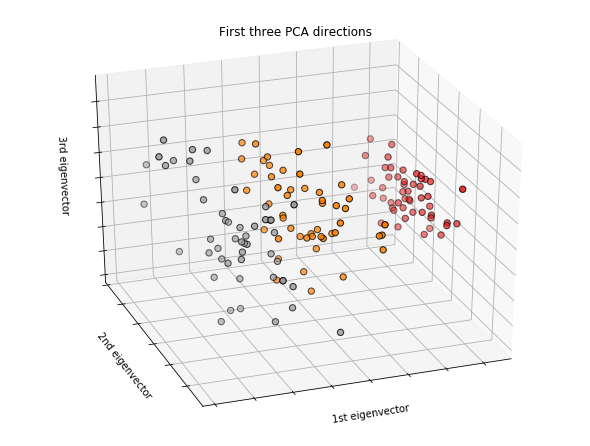

In [240]:
# Import iris dataset
print(__doc__)

# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

%matplotlib inline

# import some data to play with
# this contains 4 features: Sepal Length, Sepal Width, Petal Length and Petal Width
iris = datasets.load_iris()
data = iris.data
X = iris.data[:, :2]  # we only take two features, so that we can plot. 
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [215]:
# Function to compare clustering algorithms (from HDBSCAN page)
import time 

def plot_clusters(data, algorithm, args, kwargs):
    start_time = time.time()
    labels = algorithm(*args, **kwargs).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    try:
        plot_kwds = kwargs['plot_kwds']
    except:
        plot_kwds = {}
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    #frame.axes.get_xaxis().set_visible(False)
    #frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #plt.text(4.5, 2.0, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    plt.show()
    print('Clustering took {:.2f} s'.format(end_time - start_time))

---
---
## K-Means Clustering
---

Centroid based

Uses hard assignments to partition data

K must be assigned beforehand

${x_i}$ = data set

$r_{nk}$ = indicator variable, 1 if $x_n$ in cluster k

COST: $J = \sum \limits_{n=1}^{N} \sum \limits_{k=1}^K r_{nk} D(x_n,\mu_k)$

Distance Measure = D = $|x_n - \mu_k|^2$ For K-Means

**Algorithm:**

1. Randomize initial centroids (or smarter with K-Means ++)
2. Assign $x_i$ to closest centroid.
3. Recalculate centroids as average of members of cluster.
4. Repeat until converged. 

**Parameters to vary:**

* n_clusters
* init: method to initialize centroids (default is k-means++)
* max_iter: will eventually stop if it doesn't converge quickly

**Pros:**

* Fast
* Easy to implement

**Cons:**

* Sensitive to initial centroids
* Non-convex (many minima to get stuck in)
* Cannot do categorical variables
* Must use Euclidean distances

In [61]:
# Do some k-means stuff
from sklearn.cluster import KMeans

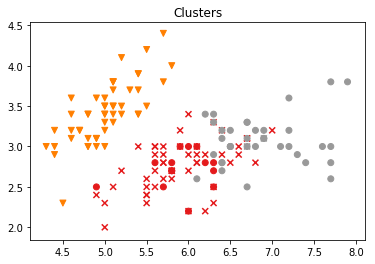

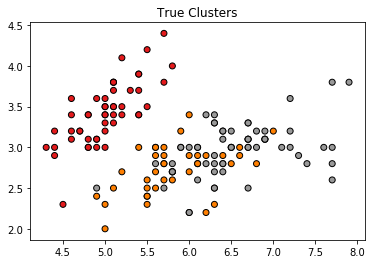

In [241]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(iris.data)
ycluster = kmeans.labels_

# Clusters the results, with correct classes as shapes 
fig, ax = plt.subplots()
ax.scatter(X[y==0,0],X[y==0,1], marker='v',c=ycluster[y==0],cmap='Set1',vmin=0., vmax=2)
ax.scatter(X[y==1,0],X[y==1,1], marker='x',c=ycluster[y==1],cmap='Set1',vmin=0., vmax=2)
ax.scatter(X[y==2,0],X[y==2,1], marker='o',c=ycluster[y==2],cmap='Set1',vmin=0., vmax=2)
plt.title('Clusters')
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.title('True Clusters')
plt.show()

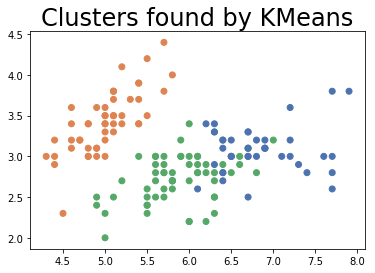

Clustering took 0.03 s


In [216]:
plot_clusters(data, KMeans, (), {'n_clusters':3})

## Hiearchial Clustering

Can be **agglomerative** (leaf-to-root) or **divisive** (root-to-leaf)

First builds tree, then operates on tree depth to determine cluster memberships.

Requires a **linkage** function to compare between different clusters

Examples: 

<img src = "../Images/linkages.png" width = 600>

**Algorithm:**

1. Construct decision tree on data
    * If agglomerative: assign each to own cluster, compute similarity, join most similar
    * If divisive: assign all to one cluster, partition into pairs, select split that maximizes distance between daughters
2. Algorithm that operates on tree depth to determine cluster memberships

**Parameters:**

* n_clusters
* affinity: metric to compute linkage
* linkage: measure of cluster closeness 

**Pros:**

* Good when data has hierarchial structure
* Can do categorical variables
* Can use general distance functions

**Cons:**

* $\mathcal{O}(n^2)$ vs kmeans $\mathcal{O}(n)$
* Greedy algorithm

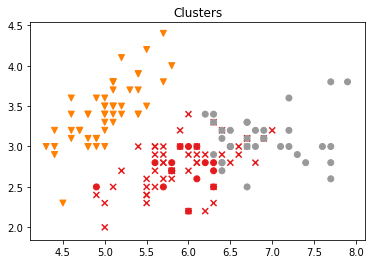

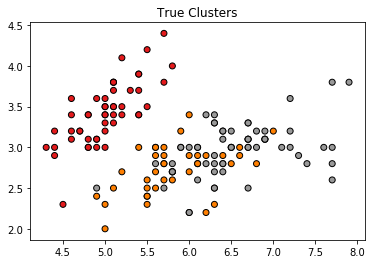

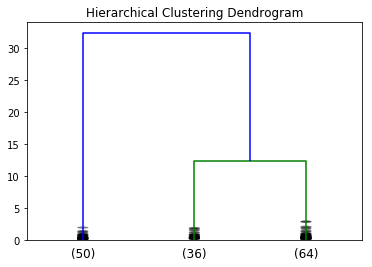

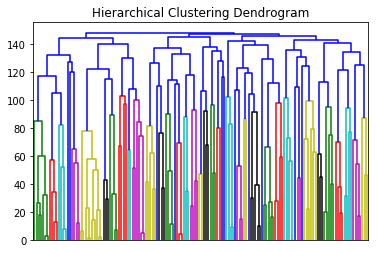

In [242]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np

def plot_dendrogram(model, **kwargs):
    # Authors: Mathew Kallada
    # License: BSD 3 clause

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


agglom = AgglomerativeClustering(n_clusters=3)
agglom.fit(iris.data)
ycluster = agglom.labels_

# Clusters the results, with correct classes as shapes 
fig, ax = plt.subplots()
ax.scatter(X[y==0,0],X[y==0,1], marker='v',c=ycluster[y==0],cmap='Set1',vmin=0., vmax=2)
ax.scatter(X[y==1,0],X[y==1,1], marker='x',c=ycluster[y==1],cmap='Set1',vmin=0., vmax=2)
ax.scatter(X[y==2,0],X[y==2,1], marker='o',c=ycluster[y==2],cmap='Set1',vmin=0., vmax=2)
plt.title('Clusters')
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.title('True Clusters')
plt.show()

# Dendrogram
#figure = plt.figure(figsize=(7.5, 5))
linkage_matrix = linkage(iris.data, 'ward')
plt.title('Hierarchical Clustering Dendrogram')
#plot_dendrogram(agglom, labels=agglom.labels_,
#    truncate_mode='lastp',  # show only the last p merged clusters
#    p=30,  # show only the last p merged clusters
#    show_contracted=True,  # to get a distribution impression in truncated branches
#)
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
    #leaf_rotation=90.,
    #leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    labels=agglom.labels_,
)
plt.show()

plt.title('Hierarchical Clustering Dendrogram')
colors = ['r','g','b']
#plot_dendrogram(agglom, truncate_mode = 'level',p=3,labels=agglom.labels_)
                #link_color_func=lambda k: colors[k%3])
plot_dendrogram(agglom, no_labels=True)
plt.show()

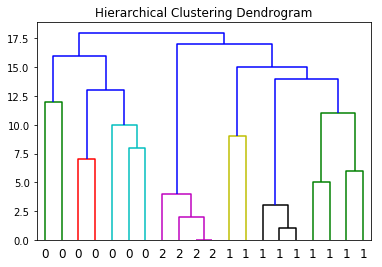

In [243]:
# Less data for more legibility
x = iris.data[:20]
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(x)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()

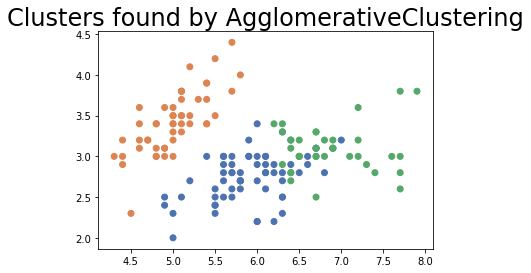

Clustering took 0.00 s


In [217]:
plot_clusters(data, AgglomerativeClustering, (), {'n_clusters':3})

## Mixture Models

Do clustering probabilistically

Assume high dimensional probability mixture (**multimodal**)

Peaks = high densities of data points

Example:

**Gaussian Mixture Model (GMM)**

$ p(x) = \sum \limits_{i=1}^K \phi_i \mathcal{N}(x | \mu, \Sigma_i) $

$ \sum \phi_i = 1 $

$ \gamma_{ik} = P(C_k | x_i, \phi, \Sigma, \mu) = \frac{ \phi_k \mathcal{N}(x_i | \mu_k,\Sigma_k)}{\sum \phi_j \mathcal{N}(x_i|\mu_j, \Sigma_j)} $

Cluster($x_i$) = $ \underset{k}{argmax}~~\gamma_{ik}$

**Algorithm:**

1. Expectation Step (E): calculate expectation of component assignments Ck
2. Maximization Step (M): maximize expecations, update $\phi,\mu,\Sigma$

**Parameters:**

* n_components
* covariance_type: can use different relationships between $\Sigma$ of different components
* n_init: number of initializations to do, keeps best

**Pros:**

* Less a-priori assumptions needed

**Cons:**

* Less intuitive
* Complex computationally?
* Needs inherenent probabilistic density (not categorical)

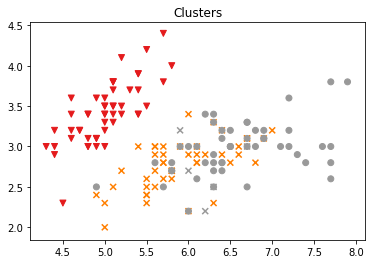

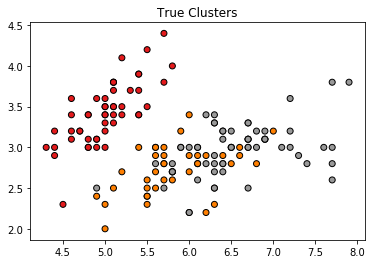

In [244]:
from sklearn.mixture import GaussianMixture

Gauss = GaussianMixture(n_components=3)
Gauss.fit(iris.data)
ycluster = Gauss.predict(iris.data)

# Clusters the results, with correct classes as shapes 
fig, ax = plt.subplots()
ax.scatter(X[y==0,0],X[y==0,1], marker='v',c=ycluster[y==0],cmap='Set1',vmin=0., vmax=2)
ax.scatter(X[y==1,0],X[y==1,1], marker='x',c=ycluster[y==1],cmap='Set1',vmin=0., vmax=2)
ax.scatter(X[y==2,0],X[y==2,1], marker='o',c=ycluster[y==2],cmap='Set1',vmin=0., vmax=2)
plt.title('Clusters')
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.title('True Clusters')
plt.show()

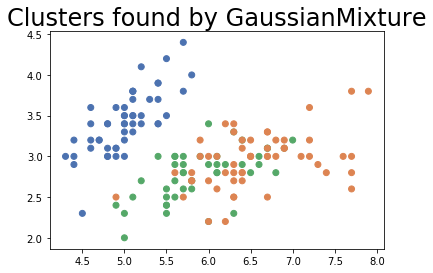

Clustering took 0.02 s


In [239]:
plot_clusters(data, GaussianMixture, (), {'n_components':3})

## DBSCAN

Density based, don't need to choose k ahead of time.

Instead, use minimum cluster members

Must specify:

* A radius to determine 'closeness'
* Number of minpoints within radius to be considered a 'core point'


**Algorithm:**

1. Initialize with arbitrary point: check if core point.
    * If it is, add reachable points to cluster
2. For all cluster points: check if core points, repeat 1. 

**Parameters:**

* eps: equivalent to radius
* min_samples
* metric: to calculate distances (also require parameter p if Minkowski metric)

**Pros:**

* Works well in non-convex regions
* Non-parametric

**Cons:**

* Some points don't get assigned.
* Complex computationally to test new points. 

Number of Clusters Found:  4


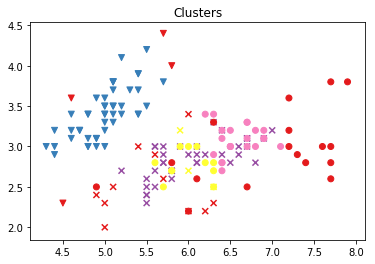

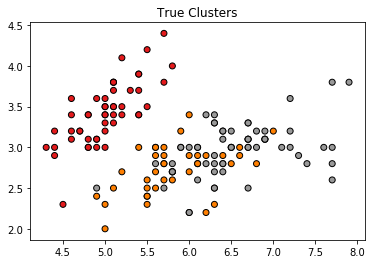

In [259]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.4, min_samples = 5)
dbscan.fit(iris.data)
ycluster = dbscan.labels_

print('Number of Clusters Found: ',ycluster.max()+1)
vmax = ycluster.max()+1
vmin = ycluster.min()

# Clusters the results, with correct classes as shapes 
fig, ax = plt.subplots()
ax.scatter(X[y==0,0],X[y==0,1], marker='v',c=ycluster[y==0],cmap='Set1',vmin=vmin, vmax=vmax)
ax.scatter(X[y==1,0],X[y==1,1], marker='x',c=ycluster[y==1],cmap='Set1',vmin=vmin, vmax=vmax)
ax.scatter(X[y==2,0],X[y==2,1], marker='o',c=ycluster[y==2],cmap='Set1',vmin=vmin, vmax=vmax)
plt.title('Clusters')
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.title('True Clusters')
plt.show()

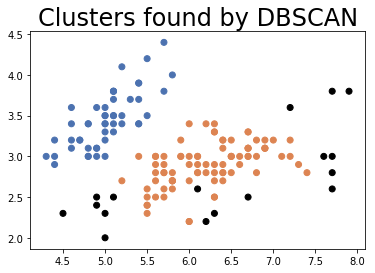

Clustering took 0.00 s


In [254]:
plot_clusters(data, DBSCAN, (), {})

---
---
## HDBSCAN
---

Density + Hierarchial based

**Algorithm:**

1. Transform the space according to the density/sparsity.
2. Build the minimum spanning tree of the distance weighted graph.
3. Construct a cluster hierarchy of connected components.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

**Main important parameters:**

* min_cluster_size
* min_samples -> larger = more conservative, more data considered noise (need to be more dense) (Default = min_cluster_size)

**Pros:**

* Don't need to choose cluster size

**Cons:**

* Expensive computationally
* Harder to interpret parameters

Number of Clusters Found:  2


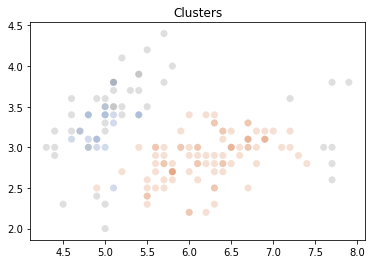

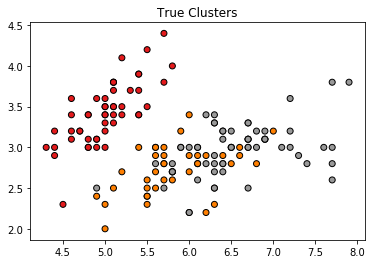

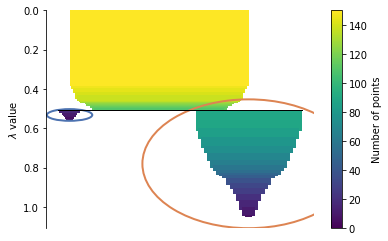

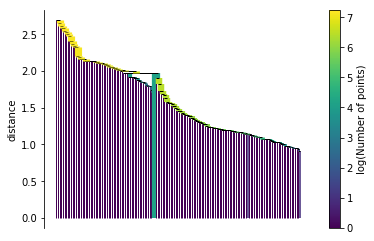

In [253]:
# Hierarchial, Density Based
import hdbscan
import seaborn as sns

min_cluster_size = 5
min_samples = 50

clusterer = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_samples)
clusterer.fit(iris.data)
ycluster = clusterer.labels_
print('Number of Clusters Found: ',clusterer.labels_.max()+1)

# Coloring according to probability of being in cluster
color_palette = sns.color_palette('deep', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*X.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.title('Clusters')
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.title('True Clusters')
plt.show()

# Show how the tree is created, identifying surviving clusters
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))
plt.show()

clusterer.single_linkage_tree_.plot()
plt.show()

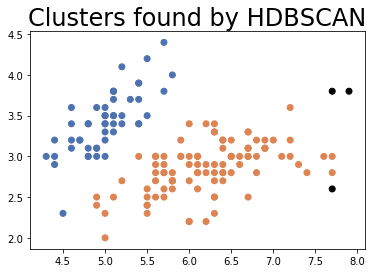

Clustering took 0.01 s


In [233]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':20,'min_samples':20})